In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
awsaf49_brats20_dataset_training_validation_path = kagglehub.dataset_download('awsaf49/brats20-dataset-training-validation')

print('Data source import complete.')
print(awsaf49_brats20_dataset_training_validation_path)

Data source import complete.
/kaggle/input/brats20-dataset-training-validation


In [ ]:
train_dir = os.path.join(awsaf49_brats20_dataset_training_validation_path,'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData')
val_dir = os.path.join(awsaf49_brats20_dataset_training_validation_path,'BraTS2020_ValidationData','MICCAI_BraTS2020_ValidationData')
print(train_dir)
print(val_dir)

/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData


In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, patient_list, data_dir, is_train=True, transform=None, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.is_train = is_train
        self.transform = transform
        self.modalities = ["flair", "t1", "t1ce", "t2"]
        self.patients = [p for p in patient_list if not p.endswith(".csv")]
        self.slice_range = slice_range  # Only load a range of slices to save memory

    def load_nifti(self, path):
        nifti_img = nib.load(path)
        return np.array(nifti_img.get_fdata(), dtype=np.float32)

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.data_dir, patient_id)

        # Load 4 MR modalities
        images = []
        for modality in self.modalities:
            img_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            img = self.load_nifti(img_path)

            # Only keep the central axial slices where tumor is most likely to be visible
            start_slice, end_slice = self.slice_range
            img = img[:, :, start_slice:end_slice]

            # Z-score normalization for better stability
            if np.std(img) > 0:
                img = (img - np.mean(img)) / np.std(img)
            else:
                img = np.zeros_like(img)

            images.append(img)

        # Stack images as channels
        images = np.stack(images, axis=0)  # (4, H, W, D_reduced)

        # To PyTorch Tensor
        images = torch.tensor(images, dtype=torch.float32)

        # If it is a train_set load segmentation mask too
        if self.is_train:
            # Try multiple possible segmentation file names
            seg_paths = [
                os.path.join(patient_path, f"{patient_id}_seg.nii"),
                os.path.join(patient_path, f"{patient_id}_Segm.nii"),
                os.path.join(patient_path, f"{patient_id}_Segmentation.nii")
            ]

            # Find the first existing segmentation file
            seg_path = next((path for path in seg_paths if os.path.exists(path)), None)

            if seg_path is None:
                raise FileNotFoundError(f"No segmentation file found for patient {patient_id}")

            mask = self.load_nifti(seg_path)

            # Get the same slice range
            mask = mask[:, :, self.slice_range[0]:self.slice_range[1]]

            # Convert to binary mask
            mask = (mask > 0).astype(np.float32)
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = None

        return (images, mask) if self.is_train else images

# Optimize memory by selecting a subset of patients for quick testing
def get_subset_patients(patient_list, ratio=0.3):
    """Get a subset of patients for memory-efficient training"""
    n_patients = max(2, int(len(patient_list) * ratio))
    return random.sample(patient_list, n_patients)

In [ ]:
# Prepare datasets (with memory optimization)
all_train_patients = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
all_test_patients = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

# For quick testing/debugging, use smaller subset
use_subset = True  # Set to False for full training
if use_subset:
    all_train_patients = get_subset_patients(all_train_patients, ratio=0.2)
    all_test_patients = get_subset_patients(all_test_patients, ratio=0.2)

print(f"Using {len(all_train_patients)} training patients and {len(all_test_patients)} test patients")

# Split training data into train and validation
train_patients, val_patients = train_test_split(all_train_patients, test_size=0.2, random_state=42)

# Create datasets with reduced slice range to save memory
train_dataset = BraTSDataset(train_patients, train_dir, slice_range=(60, 100))
val_dataset = BraTSDataset(val_patients, train_dir, slice_range=(60, 100))
test_dataset = BraTSDataset(all_test_patients, val_dir, is_train=False, slice_range=(60, 100))

# DataLoaders with small batch_size but more workers if available
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Check sample data dimensions
sample_img, sample_mask = next(iter(train_loader))
print(f"Train set image dimension: {sample_img.shape}")  # Should be smaller now
print(f"Train set segmentation dimension: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print("Validation set image dimension:", sample_img.shape)
print("Validation set segmentation dimension:", sample_mask.shape)

sample_img = next(iter(test_loader))
print("Test set image dimension:", sample_img.shape)

Using 73 training patients and 25 test patients
Train set image dimension: torch.Size([1, 4, 240, 240, 40])
Train set segmentation dimension: torch.Size([1, 240, 240, 40])
Validation set image dimension: torch.Size([1, 4, 240, 240, 40])
Validation set segmentation dimension: torch.Size([1, 240, 240, 40])
Test set image dimension: torch.Size([1, 4, 240, 240, 40])


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using Tesla T4 for training.


In [ ]:
# Improved 3D UNet with residual connections and deeper architecture
class ImprovedUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, base_filters=32):
        super(ImprovedUNet3D, self).__init__()

        # Encoder path with residual blocks
        self.enc1 = self._make_layer(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc2 = self._make_layer(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.enc3 = self._make_layer(base_filters*2, base_filters*4)

        # Decoder path with skip connections
        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = self._make_layer(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = self._make_layer(base_filters*2, base_filters)

        # Output layer with dropout for regularization
        self.dropout = nn.Dropout3d(0.25)
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)

        # Initialize weights for better convergence
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels):
        """Create a residual block"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # More stable than BatchNorm for small batches
            nn.LeakyReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm3d):
                if m.weight is not None:  # Eğer weight tanımlıysa
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:  # Eğer bias tanımlıysa
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)
        p1 = self.pool1(enc1_out)

        enc2_out = self.enc2(p1)
        p2 = self.pool2(enc2_out)

        # Bottom level
        enc3_out = self.enc3(p2)

        # Decoder with skip connections
        up2 = self.upconv2(enc3_out)
        # Ensure sizes match for skip connection
        diffY = enc2_out.size()[2] - up2.size()[2]
        diffX = enc2_out.size()[3] - up2.size()[3]
        diffZ = enc2_out.size()[4] - up2.size()[4]

        up2 = F.pad(up2, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat2 = torch.cat([up2, enc2_out], dim=1)
        dec2_out = self.dec2(concat2)

        up1 = self.upconv1(dec2_out)
        # Ensure sizes match for skip connection
        diffY = enc1_out.size()[2] - up1.size()[2]
        diffX = enc1_out.size()[3] - up1.size()[3]
        diffZ = enc1_out.size()[4] - up1.size()[4]

        up1 = F.pad(up1, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(concat1)

        # Apply dropout for regularization
        x = self.dropout(dec1_out)

        # Final classification layer
        out = self.final_conv(x)

        return out

In [ ]:
# Dice Loss implementation for better segmentation results
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Flatten tensors
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        # Compute Dice coefficient
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)

        return 1 - dice

# Combination of CrossEntropy and Dice loss for better performance
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # Cross entropy component
        ce_loss = self.ce_loss(inputs, targets)

        # Get predicted class probabilities for dice loss
        probs = F.softmax(inputs, dim=1)

        # Get binary predictions for the positive class (index 1)
        predicted_class = probs[:, 1]
        target_one_hot = torch.zeros_like(probs)
        target_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        target_class = target_one_hot[:, 1]

        # Compute dice loss on the positive (tumor) class
        dice_loss = self.dice_loss(predicted_class, target_class)

        # Combine losses
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

In [ ]:
# Initialize model with improved architecture
model = ImprovedUNet3D(in_channels=4, out_channels=2, base_filters=16)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Use combined loss for better segmentation results
criterion = CombinedLoss(weight_dice=0.7, weight_ce=0.3)

# Cosine annealing learning rate for better convergence
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# Updated Dice coefficient for evaluation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    # Flatten tensors
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)

    # Calculate intersection and dice coefficient
    intersection = (y_pred * y_true).sum()
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

    return dice.item()

In [ ]:
class SegmentationMetrics:
    """Classe pour calculer toutes les métriques de segmentation"""

    def __init__(self, smooth=1e-6):
        self.smooth = smooth

    def dice_coefficient(self, y_pred, y_true):
        """Calcule le coefficient de Dice"""
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)

        return dice.item()

    def iou_score(self, y_pred, y_true):
        """Calcule l'IoU (Intersection over Union) / Jaccard Index"""
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum() - intersection

        iou = (intersection + self.smooth) / (union + self.smooth)
        return iou.item()

    def sensitivity_recall(self, y_pred, y_true):
        """Calcule la sensibilité/rappel (True Positive Rate)"""
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        tp = (y_pred * y_true).sum()
        fn = ((1 - y_pred) * y_true).sum()

        sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)
        return sensitivity.item()

    def specificity(self, y_pred, y_true):
        """Calcule la spécificité (True Negative Rate)"""
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        tn = ((1 - y_pred) * (1 - y_true)).sum()
        fp = (y_pred * (1 - y_true)).sum()

        spec = (tn + self.smooth) / (tn + fp + self.smooth)
        return spec.item()

    def precision(self, y_pred, y_true):
        """Calcule la précision (Positive Predictive Value)"""
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        tp = (y_pred * y_true).sum()
        fp = (y_pred * (1 - y_true)).sum()

        prec = (tp + self.smooth) / (tp + fp + self.smooth)
        return prec.item()

    def f1_score(self, y_pred, y_true):
        """Calcule le F1-score"""
        precision = self.precision(y_pred, y_true)
        recall = self.sensitivity_recall(y_pred, y_true)

        f1 = (2 * precision * recall + self.smooth) / (precision + recall + self.smooth)
        return f1

    def hausdorff_distance_95(self, y_pred, y_true):
        """Calcule une approximation de la distance de Hausdorff 95ème percentile"""
        try:
            # Convertir en numpy
            y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred
            y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else y_true

            # Trouver les contours
            pred_points = np.argwhere(y_pred_np > 0.5)
            true_points = np.argwhere(y_true_np > 0.5)

            if len(pred_points) == 0 or len(true_points) == 0:
                return float('inf')

            # Calculer les distances
            from scipy.spatial.distance import cdist
            distances1 = cdist(pred_points, true_points).min(axis=1)
            distances2 = cdist(true_points, pred_points).min(axis=1)

            # Prendre le 95ème percentile
            all_distances = np.concatenate([distances1, distances2])
            hd95 = np.percentile(all_distances, 95)

            return hd95
        except:
            return float('inf')

    def volume_similarity(self, y_pred, y_true):
        """Calcule la similarité volumétrique"""
        vol_pred = y_pred.sum()
        vol_true = y_true.sum()

        if vol_pred == 0 and vol_true == 0:
            return 1.0

        vs = 1.0 - abs(vol_pred - vol_true) / (vol_pred + vol_true)
        return vs.item() if torch.is_tensor(vs) else vs

    def compute_all_metrics(self, y_pred, y_true):
        """Calcule toutes les métriques en une fois"""
        metrics = {
            'dice': self.dice_coefficient(y_pred, y_true),
            'iou': self.iou_score(y_pred, y_true),
            'precision': self.precision(y_pred, y_true),
            'recall': self.sensitivity_recall(y_pred, y_true),
            'specificity': self.specificity(y_pred, y_true),
            'f1_score': self.f1_score(y_pred, y_true),
            'volume_similarity': self.volume_similarity(y_pred, y_true),
            # 'hausdorff_95': self.hausdorff_distance_95(y_pred, y_true)  # Commenté car coûteux
        }
        return metrics

# Initialize metrics calculator
metrics_calculator = SegmentationMetrics()

# Loss functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)

        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)

        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)

        probs = F.softmax(inputs, dim=1)
        predicted_class = probs[:, 1]
        target_one_hot = torch.zeros_like(probs)
        target_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        target_class = target_one_hot[:, 1]

        dice_loss = self.dice_loss(predicted_class, target_class)

        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

In [ ]:
# Initialize model
model = ImprovedUNet3D(in_channels=4, out_channels=2, base_filters=16)
model = model.to(device)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

criterion = CombinedLoss(weight_dice=0.7, weight_ce=0.3)

optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)


In [ ]:
# Updated training function with all metrics
def train_one_epoch_with_metrics(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0.0
    epoch_metrics = {
        'dice': 0.0, 'iou': 0.0, 'precision': 0.0, 'recall': 0.0,
        'specificity': 0.0, 'f1_score': 0.0, 'volume_similarity': 0.0
    }
    batch_count = 0

    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        epoch_loss += loss.item()

        # Get predictions
        if outputs.shape[1] > 1:
            _, preds = torch.max(outputs, 1)
        else:
            preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate all metrics
        batch_metrics = metrics_calculator.compute_all_metrics(preds, targets)

        for key in epoch_metrics.keys():
            epoch_metrics[key] += batch_metrics[key]

        batch_count += 1

        if (i+1) % 5 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}, "
                  f"Dice: {batch_metrics['dice']:.4f}, IoU: {batch_metrics['iou']:.4f}")

        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()

    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_metrics = {key: value / batch_count for key, value in epoch_metrics.items()}

    return avg_loss, avg_metrics

def validate_one_epoch_with_metrics(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    epoch_metrics = {
        'dice': 0.0, 'iou': 0.0, 'precision': 0.0, 'recall': 0.0,
        'specificity': 0.0, 'f1_score': 0.0, 'volume_similarity': 0.0
    }
    batch_count = 0

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            epoch_loss += loss.item()

            if outputs.shape[1] > 1:
                _, preds = torch.max(outputs, 1)
            else:
                preds = (torch.sigmoid(outputs) > 0.5).float()

            # Calculate all metrics
            batch_metrics = metrics_calculator.compute_all_metrics(preds, targets)

            for key in epoch_metrics.keys():
                epoch_metrics[key] += batch_metrics[key]

            batch_count += 1

            del inputs, targets, outputs, preds
            torch.cuda.empty_cache()

    avg_loss = epoch_loss / batch_count
    avg_metrics = {key: value / batch_count for key, value in epoch_metrics.items()}

    return avg_loss, avg_metrics

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0


Epoch [1/100]
Batch 5/58, Loss: 0.7969, Dice: 0.1093, IoU: 0.0578
Batch 10/58, Loss: 0.7710, Dice: 0.2360, IoU: 0.1338
Batch 15/58, Loss: 0.6495, Dice: 0.4249, IoU: 0.2697
Batch 20/58, Loss: 0.9609, Dice: 0.0339, IoU: 0.0172
Batch 25/58, Loss: 0.6213, Dice: 0.4459, IoU: 0.2869
Batch 30/58, Loss: 0.6848, Dice: 0.2616, IoU: 0.1505
Batch 35/58, Loss: 0.4331, Dice: 0.7618, IoU: 0.6152
Batch 40/58, Loss: 0.9897, Dice: 0.0651, IoU: 0.0336
Batch 45/58, Loss: 0.6796, Dice: 0.2258, IoU: 0.1273
Batch 50/58, Loss: 0.7290, Dice: 0.1844, IoU: 0.1015
Batch 55/58, Loss: 0.5249, Dice: 0.5189, IoU: 0.3504
Epoch [1/100]
Train - Loss: 0.7101, Dice: 0.3036, IoU: 0.2041, F1: 0.3036
Val   - Loss: 0.5086, Dice: 0.5926, IoU: 0.4701, F1: 0.5926
Val   - Precision: 0.5146, Recall: 0.9134, Specificity: 0.9756
LR: 0.000200
Best model saved with IoU: 0.4701, Dice: 0.5926!
Epoch [2/100]
Batch 5/58, Loss: 0.3035, Dice: 0.7730, IoU: 0.6300
Batch 10/58, Loss: 0.2795, Dice: 0.8603, IoU: 0.7549
Batch 15/58, Loss: 0.2721,

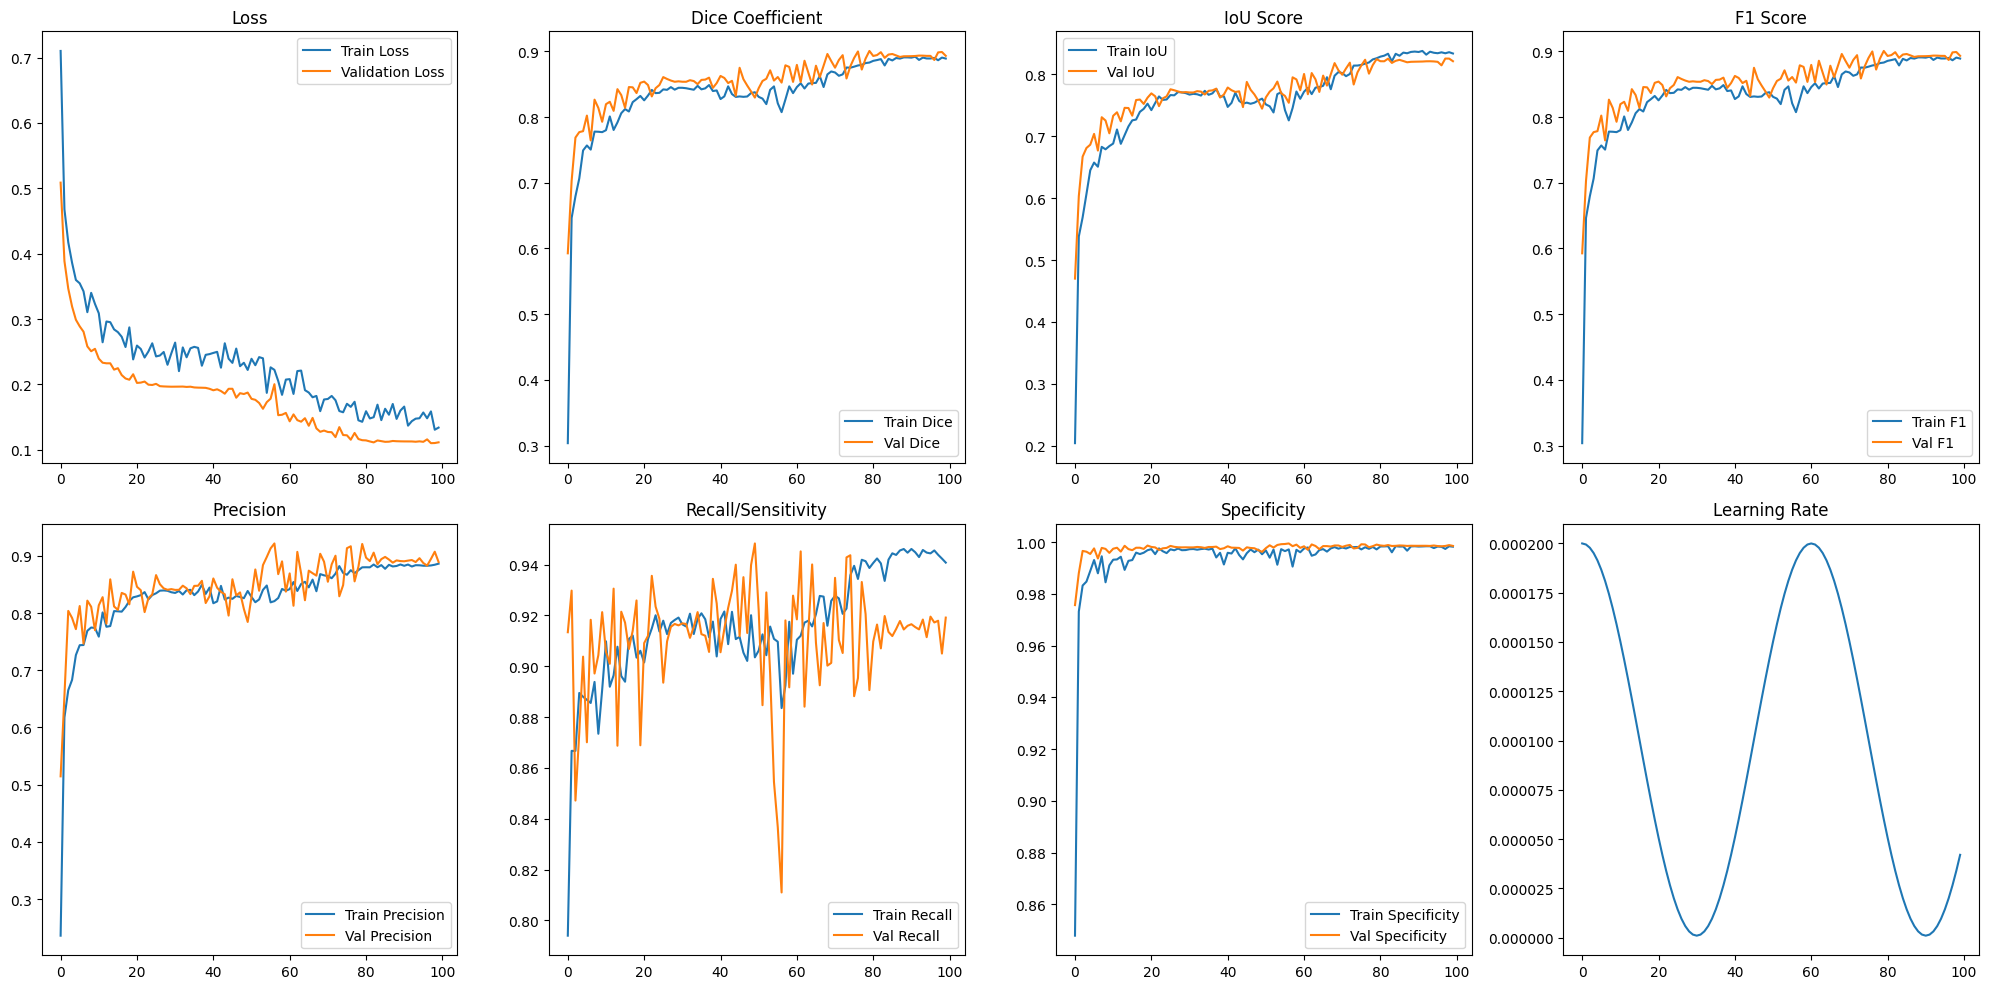

Training completed!
Best validation Dice score: 0.8985
Best validation IoU score: 0.8257


In [ ]:
# Training loop with enhanced metrics
num_epochs = 100
best_val_dice = 0.0
best_val_iou = 0.0
early_stopping = EarlyStopping(patience=15)

# Lists to store all metrics
train_losses = []
val_losses = []
train_metrics_history = {
    'dice': [], 'iou': [], 'precision': [], 'recall': [],
    'specificity': [], 'f1_score': [], 'volume_similarity': []
}
val_metrics_history = {
    'dice': [], 'iou': [], 'precision': [], 'recall': [],
    'specificity': [], 'f1_score': [], 'volume_similarity': []
}
learning_rates = []

try:
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")

        # Train with metrics
        train_loss, train_metrics = train_one_epoch_with_metrics(
            model, train_loader, optimizer, criterion, device, scaler
        )
        train_losses.append(train_loss)

        for key in train_metrics_history.keys():
            train_metrics_history[key].append(train_metrics[key])

        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        scheduler.step()

        torch.cuda.empty_cache()

        # Validate with metrics
        val_loss, val_metrics = validate_one_epoch_with_metrics(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)

        for key in val_metrics_history.keys():
            val_metrics_history[key].append(val_metrics[key])

        # Print comprehensive results
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train - Loss: {train_loss:.4f}, Dice: {train_metrics['dice']:.4f}, "
              f"IoU: {train_metrics['iou']:.4f}, F1: {train_metrics['f1_score']:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_metrics['dice']:.4f}, "
              f"IoU: {val_metrics['iou']:.4f}, F1: {val_metrics['f1_score']:.4f}")
        print(f"Val   - Precision: {val_metrics['precision']:.4f}, "
              f"Recall: {val_metrics['recall']:.4f}, Specificity: {val_metrics['specificity']:.4f}")
        print(f"LR: {current_lr:.6f}")

        # Save best model based on IoU score
        if val_metrics['iou'] > best_val_iou:
            best_val_iou = val_metrics['iou']
            best_val_dice = val_metrics['dice']
            torch.save(model, 'best_brats_model_iou.pt')
            print(f"Best model saved with IoU: {best_val_iou:.4f}, Dice: {best_val_dice:.4f}!")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

        torch.cuda.empty_cache()

except Exception as e:
    print(f"Error during training: {e}")
    torch.save(model, 'interrupted_brats_model.pt')
    print("Model saved despite interruption!")

# Enhanced plotting with all metrics
def plot_comprehensive_metrics():
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Loss
    axes[0, 0].plot(train_losses, label='Train Loss')
    axes[0, 0].plot(val_losses, label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()

    # Dice
    axes[0, 1].plot(train_metrics_history['dice'], label='Train Dice')
    axes[0, 1].plot(val_metrics_history['dice'], label='Val Dice')
    axes[0, 1].set_title('Dice Coefficient')
    axes[0, 1].legend()

    # IoU
    axes[0, 2].plot(train_metrics_history['iou'], label='Train IoU')
    axes[0, 2].plot(val_metrics_history['iou'], label='Val IoU')
    axes[0, 2].set_title('IoU Score')
    axes[0, 2].legend()

    # F1 Score
    axes[0, 3].plot(train_metrics_history['f1_score'], label='Train F1')
    axes[0, 3].plot(val_metrics_history['f1_score'], label='Val F1')
    axes[0, 3].set_title('F1 Score')
    axes[0, 3].legend()

    # Precision
    axes[1, 0].plot(train_metrics_history['precision'], label='Train Precision')
    axes[1, 0].plot(val_metrics_history['precision'], label='Val Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].legend()

    # Recall
    axes[1, 1].plot(train_metrics_history['recall'], label='Train Recall')
    axes[1, 1].plot(val_metrics_history['recall'], label='Val Recall')
    axes[1, 1].set_title('Recall/Sensitivity')
    axes[1, 1].legend()

    # Specificity
    axes[1, 2].plot(train_metrics_history['specificity'], label='Train Specificity')
    axes[1, 2].plot(val_metrics_history['specificity'], label='Val Specificity')
    axes[1, 2].set_title('Specificity')
    axes[1, 2].legend()

    # Learning Rate
    axes[1, 3].plot(learning_rates)
    axes[1, 3].set_title('Learning Rate')

    plt.tight_layout()
    plt.savefig('comprehensive_training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

if len(train_losses) > 0:
    plot_comprehensive_metrics()

print(f"Training completed!")
print(f"Best validation Dice score: {best_val_dice:.4f}")
print(f"Best validation IoU score: {best_val_iou:.4f}")

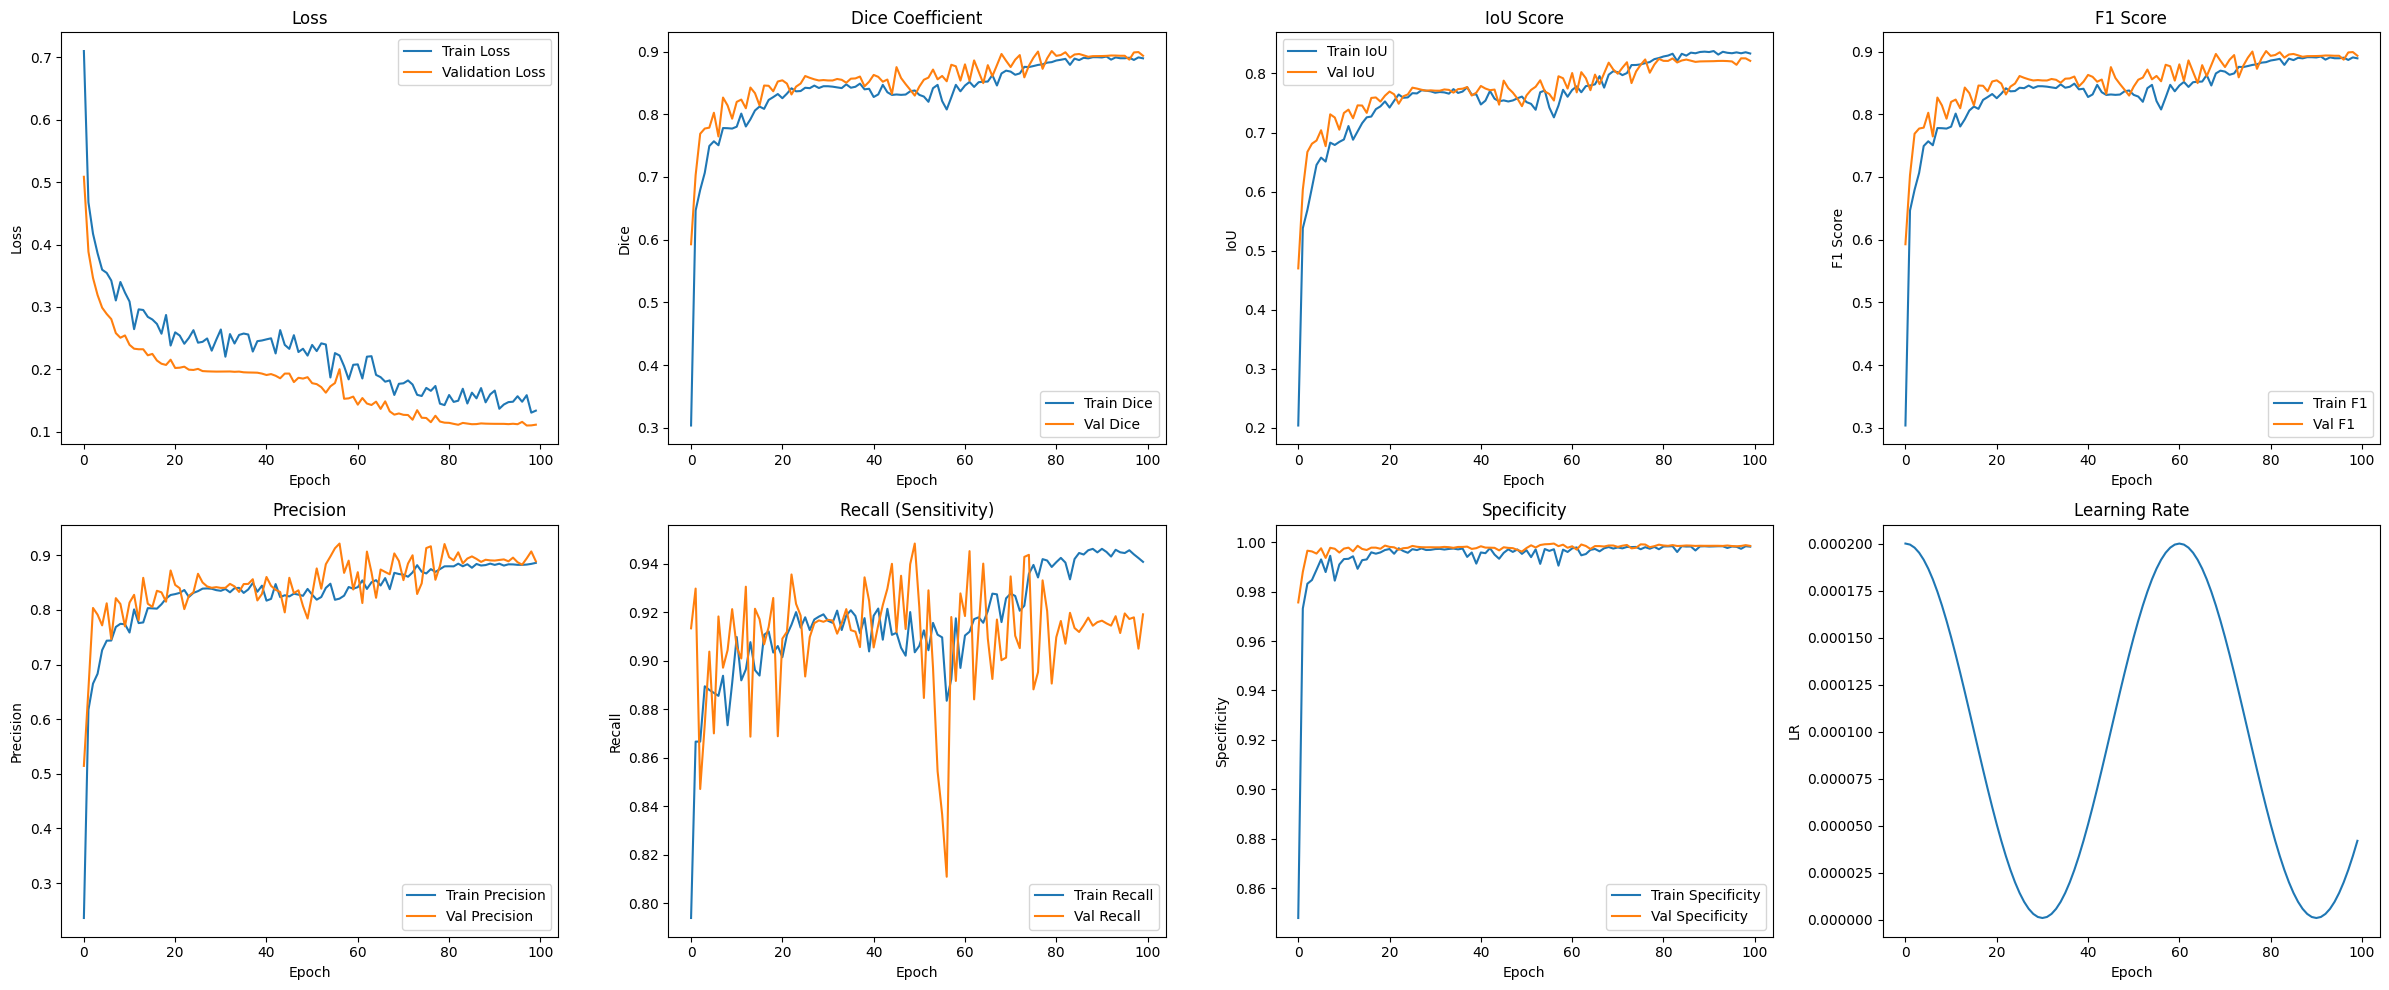

In [ ]:
# Plot metrics only if training completed
if len(train_losses) > 0:
    try:
        fig, axes = plt.subplots(2, 4, figsize=(24, 10))

        # Loss
        axes[0, 0].plot(train_losses, label='Train Loss')
        axes[0, 0].plot(val_losses, label='Validation Loss')
        axes[0, 0].set_title('Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()

        # Dice
        axes[0, 1].plot(train_metrics_history['dice'], label='Train Dice')
        axes[0, 1].plot(val_metrics_history['dice'], label='Val Dice')
        axes[0, 1].set_title('Dice Coefficient')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice')
        axes[0, 1].legend()

        # IoU
        axes[0, 2].plot(train_metrics_history['iou'], label='Train IoU')
        axes[0, 2].plot(val_metrics_history['iou'], label='Val IoU')
        axes[0, 2].set_title('IoU Score')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('IoU')
        axes[0, 2].legend()

        # F1 Score
        axes[0, 3].plot(train_metrics_history['f1_score'], label='Train F1')
        axes[0, 3].plot(val_metrics_history['f1_score'], label='Val F1')
        axes[0, 3].set_title('F1 Score')
        axes[0, 3].set_xlabel('Epoch')
        axes[0, 3].set_ylabel('F1 Score')
        axes[0, 3].legend()

        # Precision
        axes[1, 0].plot(train_metrics_history['precision'], label='Train Precision')
        axes[1, 0].plot(val_metrics_history['precision'], label='Val Precision')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()

        # Recall
        axes[1, 1].plot(train_metrics_history['recall'], label='Train Recall')
        axes[1, 1].plot(val_metrics_history['recall'], label='Val Recall')
        axes[1, 1].set_title('Recall (Sensitivity)')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()

        # Specificity
        axes[1, 2].plot(train_metrics_history['specificity'], label='Train Specificity')
        axes[1, 2].plot(val_metrics_history['specificity'], label='Val Specificity')
        axes[1, 2].set_title('Specificity')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Specificity')
        axes[1, 2].legend()

        # Learning Rate
        axes[1, 3].plot(learning_rates)
        axes[1, 3].set_title('Learning Rate')
        axes[1, 3].set_xlabel('Epoch')
        axes[1, 3].set_ylabel('LR')

        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()

    except Exception as e:
        print(f"Error creating plots: {e}")


In [ ]:
# Modeli yükle
model_path = "/content/drive/MyDrive/Intellecap_project/BrainCancer/best_brats_model_dice.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur ve ağırlıkları yükle
model = torch.load(model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval()  # Modeli inference moduna al

ImprovedUNet3D(
  (enc1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, trac

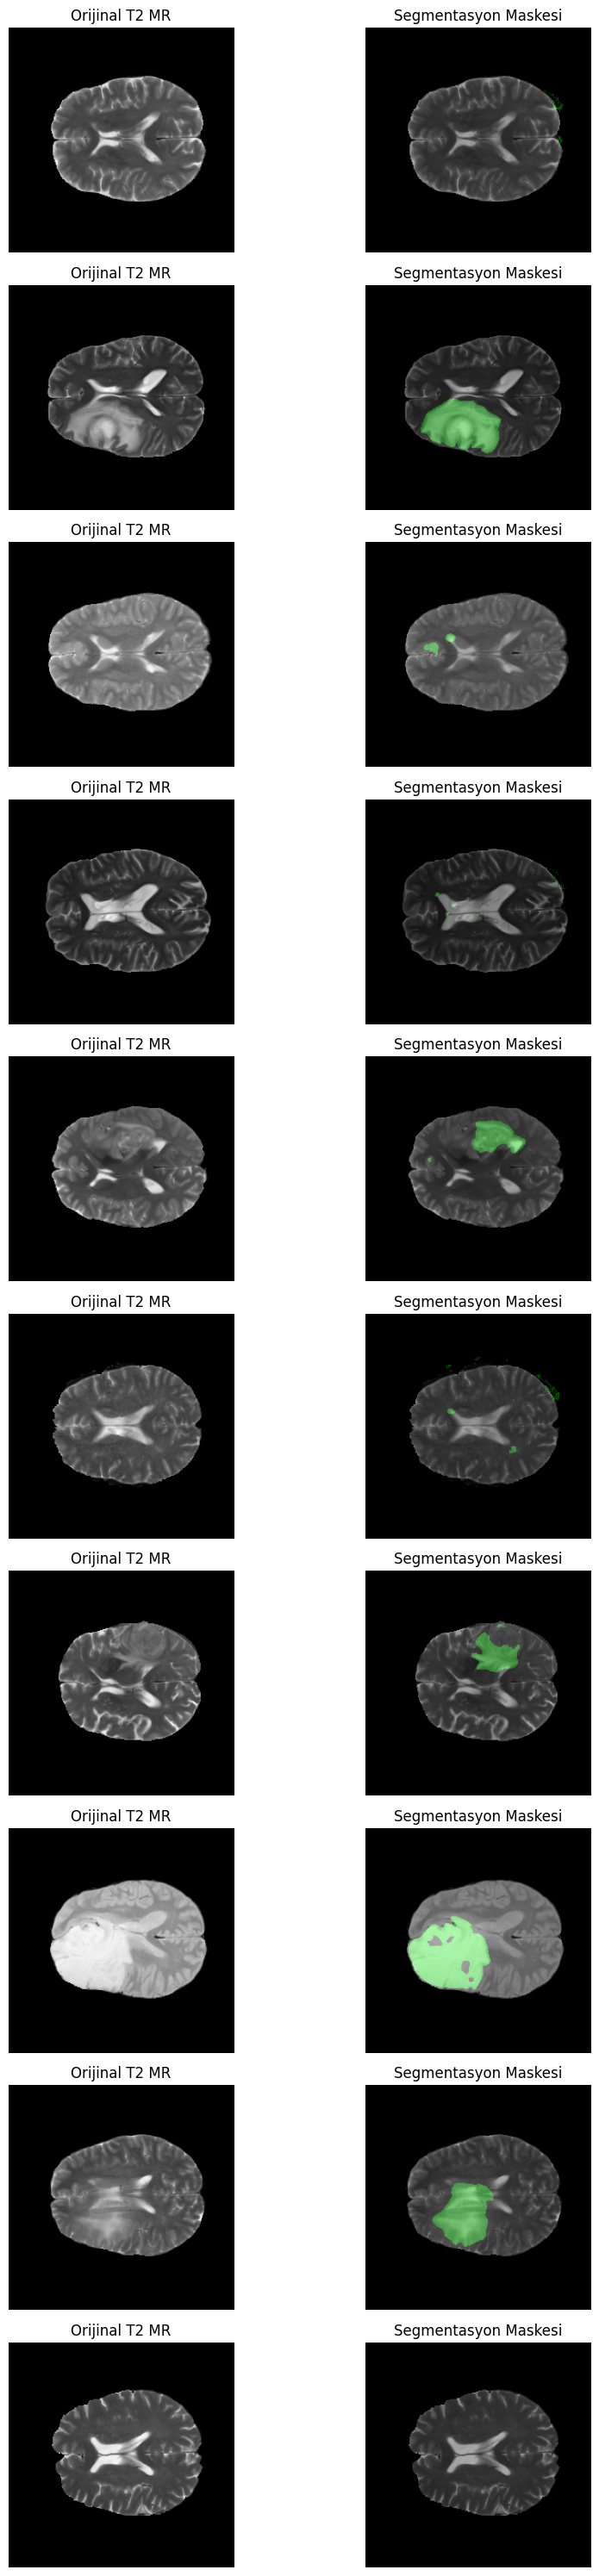

In [ ]:
# Take random 10 images
test_iter = iter(test_loader)
num_images = 10
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

for i in range(num_images):
    test_image = next(test_iter).to(device)  # (1, 4, H, W, D)

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 2, H, W, D)
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D)

    # Transform to numpy
    test_image_np = test_image.cpu().numpy()

    # Select middle slice (e.g. D/2)
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D
    t2_slice = test_image_np[0, 3, :, :, slice_idx]  # T2 modality
    pred_mask = prediction[0, :, :, slice_idx]  # Segmentation mask

    # Normalize and convert to 8-bit (For Image)
    t2_slice = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Make it colorful
    t2_colored = cv2.cvtColor(t2_slice, cv2.COLOR_GRAY2BGR)

    # Color the segmentation mask
    mask_colored = np.zeros_like(t2_colored)
    mask_colored[:, :, 1] = (pred_mask * 255).astype(np.uint8)  # Green mask

    # Overlay segmentation transparently onto image
    blended = cv2.addWeighted(t2_colored, 0.7, mask_colored, 0.3, 0)

    # Draw images
    axes[i, 0].imshow(t2_colored)
    axes[i, 0].set_title("Orijinal T2 MR")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(blended)
    axes[i, 1].set_title("Segmentasyon Maskesi")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()